# PCA of 1000 Genome Phase3 Genotype data

Fan Wang

May 11 2022

Principal components analysis (PCA) is a widely used method in the field of population genetics, providing a model-free method for exploring patterns of relatedness within a collection of individuals. In this notebook, we use the 1000 Genomes Project phase3 release of variant calls data to apply both conventional PCA analysis of the LD-pruned genotype data.

In [1]:
import random

random.seed(42)
import numpy as np

np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
import pandas as pd
import allel

sns.set(style="ticks", color_codes=True)
get_ipython().run_line_magic("config", "InlineBackend.figure_format = 'svg'")
import warnings

warnings.filterwarnings("ignore")

##  SNP genotype data is available in a VCF file

In [ ]:
!gen3 drs-pull object dg.ANV0/ae5b302c-543c-4612-94e8-91164c850fca
!gen3 drs-pull object dg.ANV0/773ee98a-0012-4458-bf4e-4dc8fcf32c97
!gen3 drs-pull object dg.ANV0/e47f807b-6084-4dba-b121-0fe704466ca4
!gen3 drs-pull object dg.ANV0/99057bf2-a394-4b1a-8e11-95964bc7542f

In [3]:
callset = allel.read_vcf("ALL.chrY.phase3_integrated_v2b.20130502.genotypes.vcf.gz")
pos = allel.SortedIndex(callset["variants/POS"])
loc_region = pos.locate_range(2655180, 28770931)

In [4]:
gt_zarr = callset["calldata/GT"]
gt = allel.GenotypeArray(gt_zarr[loc_region])
ac = gt.count_alleles()[:]

In [5]:
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
gf = gt.compress(flt, axis=0)
gn = gf.to_n_alt()

In [6]:
n = 1000
vidx = np.random.choice(gn.shape[0], n, replace=False)
vidx.sort()
gnr = gn.take(vidx, axis=0)

In [7]:
coords1, model1 = allel.pca(gnr, n_components=10, scaler="patterson")

In [8]:
df_cont = pd.read_csv("igsr_populations.tsv", delimiter="\t")
df_samples_1000g = pd.read_csv(
    "integrated_call_samples_v3.20200731.ALL.ped",
    delimiter="\t",
    index_col="Individual ID",
)
df_samples = pd.merge(
    df_samples_1000g, df_cont[["Population", "Superpopulation name"]], on="Population"
)
df_samples = df_samples.rename(columns={"Superpopulation name": "Continental"})

In [9]:
df_gnu = pd.DataFrame(data=coords1, index=callset["samples"])
df_samples = df_samples.set_index("Family ID")
df_samples.index.name = None
pca_samples = df_gnu.join(df_samples)
populations = pca_samples.Population.unique()
continents = pca_samples.Continental.unique()
cont_colours = plt.cm.rainbow(np.linspace(0, 1, len(continents)))
pop_colours = plt.cm.rainbow(np.linspace(0, 1, len(populations)))

## Removing correlated features (LD pruning)
PCA works best when the features you provide as input are independent from each other. Here each SNP is a feature, however, because DNA is transmitted from one generation to the next with some recombination between parents, genotypes at nearby SNPs tend to be correlated, with the correlation (linkage disequlibrium) decaying as you increase the separation between SNPs. For NGS data, a larger window size or multiple rounds of pruning may be required to deal with regions of long-range LD. LD pruning may also impact different populations in different ways, if populations have different levels of LD.

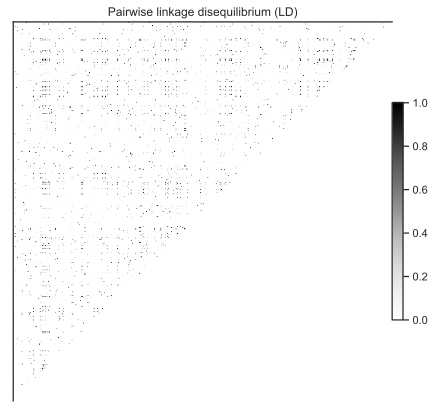

In [10]:
def plot_ld(gn, title):

    m = allel.rogers_huff_r(gn) ** 2
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    allel.plot_pairwise_ld(m, ax=ax)
    ax.set_title(title)


plot_ld(gn[:500], "Pairwise linkage disequilibrium (LD)")

We can get a sense of that correlation structure by visualising pairwise linkage disequilibrium in the first 500 SNPs. The darker regions in the plot above indicate pairs of SNPs where genotypes are correlated.

By randomly downsampling SNPs, this should have dealt with much of the correlation between nearby features. Let’s take a look at the first 500 SNPs.

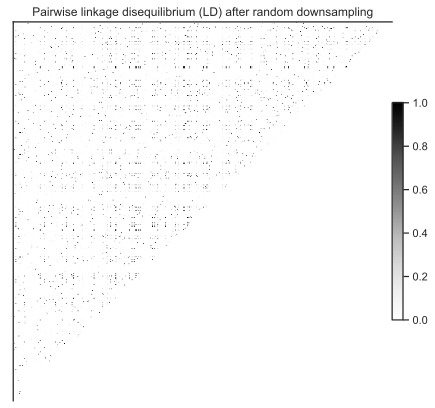

In [11]:
plot_ld(gnr[:500], "Pairwise linkage disequilibrium (LD) after random downsampling")

You can see that some of the correlations are not there anymore. However, you may be able to see some speckling, indicating that there are still some correlated SNPs in the dataset.

To remove this remaining correlation, I’m going to explicitly locate SNPs that are not correlated with each other, using the locate_unlinked function from scikit-allel. This is known as LD pruning, and works by sliding a window along the data, computing pairwise LD between all SNPs within each window, then removing one SNP from each correlated pair.

In [12]:
def ld_prune(gn, size, step, threshold=0.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(
            gn, size=size, step=step, threshold=threshold
        )
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print("iteration", i + 1, "retaining", n, "removing", n_remove, "variants")
        gn = gn.compress(loc_unlinked, axis=0)
    return gn


gnu_prune = ld_prune(gnr, size=500, step=200, threshold=0.1, n_iter=5)

iteration 1 retaining 323 removing 677 variants
iteration 2 retaining 214 removing 109 variants
iteration 3 retaining 214 removing 0 variants
iteration 4 retaining 214 removing 0 variants
iteration 5 retaining 214 removing 0 variants


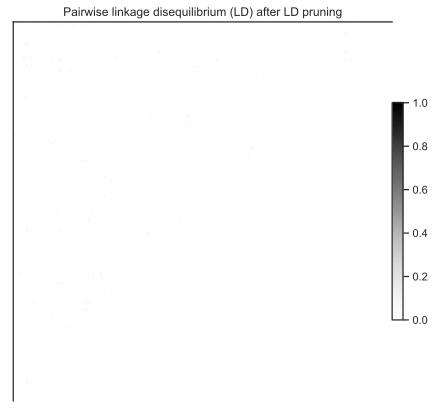

In [13]:
plot_ld(gnu_prune[:500], "Pairwise linkage disequilibrium (LD) after LD pruning")

The data are relatively small now after downsampling and LD-pruning, so we can bring the data out of chunked storage and into memory uncompressed, which is necessary for PCA.

### Continental PCA

In [14]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population, pops, pop_colors):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop, color in zip(pops, pop_colors):
        flt = sample_population == pop
        ax.plot(
            x[flt],
            y[flt],
            marker="o",
            linestyle=" ",
            color=color,
            label=pop,
            markersize=6,
            mec="k",
            mew=0.5,
        )
    ax.set_xlabel(
        "PC%s (%.1f%%)" % (pc1 + 1, model.explained_variance_ratio_[pc1] * 100)
    )
    ax.set_ylabel(
        "PC%s (%.1f%%)" % (pc2 + 1, model.explained_variance_ratio_[pc2] * 100)
    )

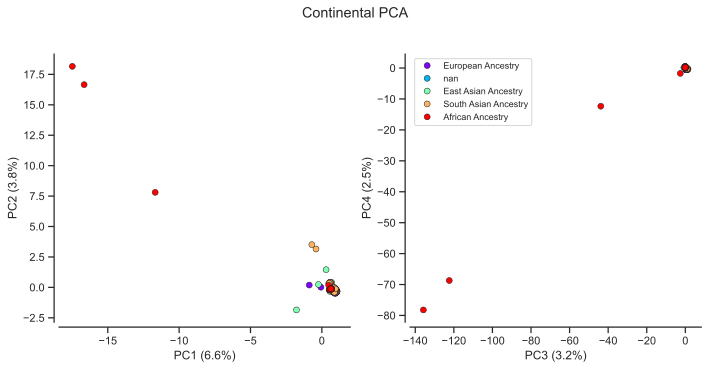

In [15]:
def fig_pca_cont(axl, ax2, coords, model, title, sample_population=None):
    if sample_population is None:
        sample_population = pca_samples.Continental.values
    plot_pca_coords(
        coords, model, 0, 1, axl, sample_population, continents, cont_colours
    )
    plot_pca_coords(
        coords, model, 2, 3, ax2, sample_population, continents, cont_colours
    )
    ax2.legend(loc="best", fontsize=9)
    fig.suptitle(title, y=1.02)
    fig.tight_layout()


fig = plt.figure(figsize=(10, 5))
axl = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

fig_pca_cont(axl, ax2, coords1, model1, "Continental PCA")

### Effect of variance scaling

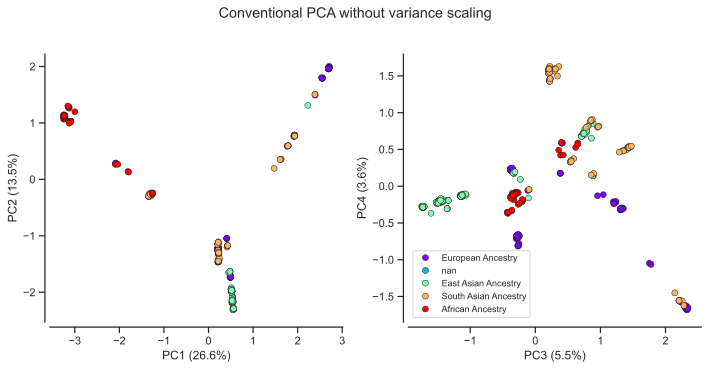

In [16]:
coords3, model3 = allel.pca(gnr, n_components=10, scaler=None)


def fig_pca_cont_pruned(axl, ax2, coords, model, title, sample_population=None):
    if sample_population is None:
        sample_population = pca_samples.Continental.values
    plot_pca_coords(
        coords, model, 0, 1, axl, sample_population, continents, cont_colours
    )
    plot_pca_coords(
        coords, model, 2, 3, ax2, sample_population, continents, cont_colours
    )
    ax2.legend(loc="best", fontsize=9)
    fig.suptitle(title, y=1.02)
    fig.tight_layout()


fig = plt.figure(figsize=(10, 5))
axl = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

fig_pca_cont_pruned(
    axl, ax2, coords3, model3, "Conventional PCA without variance scaling"
)

### Effect of LD pruning

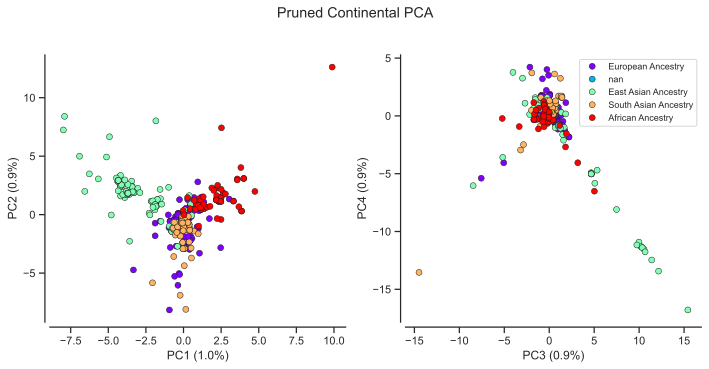

In [17]:
gnu_prune = gnu_prune[:]
coords2, model2 = allel.pca(gnu_prune, n_components=10, scaler="patterson")


def fig_pca_cont_pruned(axl, ax2, coords, model, title, sample_population=None):
    if sample_population is None:
        sample_population = pca_samples.Continental.values
    plot_pca_coords(
        coords, model, 0, 1, axl, sample_population, continents, cont_colours
    )
    plot_pca_coords(
        coords, model, 2, 3, ax2, sample_population, continents, cont_colours
    )
    ax2.legend(loc="best", fontsize=9)
    fig.suptitle(title, y=1.02)
    fig.tight_layout()


fig = plt.figure(figsize=(10, 5))
axl = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)


fig_pca_cont_pruned(axl, ax2, coords2, model2, "Pruned Continental PCA")

Looking at the left-hand plot of PC1 versus PC2, there is a clear separation of individuals into four different clusters. This indicates there are at least four genetically distinct populations.

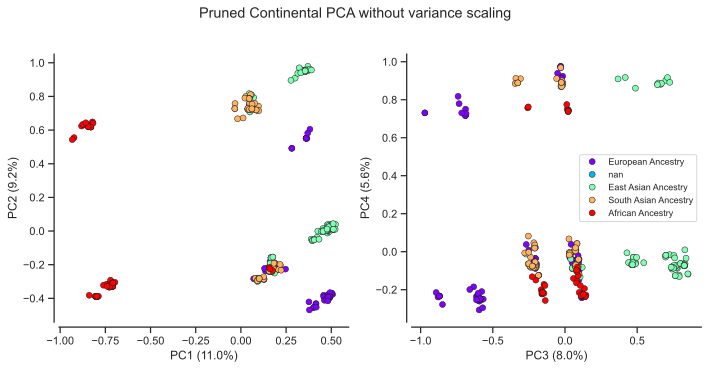

In [18]:
gnu_prune = gnu_prune[:]
coords4, model4 = allel.pca(gnu_prune, n_components=10, scaler=None)


def fig_pca_cont_pruned(axl, ax2, coords, model, title, sample_population=None):
    if sample_population is None:
        sample_population = pca_samples.Continental.values
    plot_pca_coords(
        coords, model, 0, 1, axl, sample_population, continents, cont_colours
    )
    plot_pca_coords(
        coords, model, 2, 3, ax2, sample_population, continents, cont_colours
    )
    ax2.legend(loc="best", fontsize=9)
    fig.suptitle(title, y=1.02)
    fig.tight_layout()


fig = plt.figure(figsize=(10, 5))
axl = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)


fig_pca_cont_pruned(
    axl, ax2, coords4, model4, "Pruned Continental PCA without variance scaling"
)

Here again the same clusters are visible but are resolved in a different way. Also, note more of the total variance is explained by the first four components than when using the Patterson scaler. 